# <center><b> Customer Segmentation</center>

# **Load Datasets**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
## Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

from scipy import stats
from scipy.stats import norm, skew 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
# clustering algorithms
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_samples, silhouette_score

In [7]:
customer_df = pd.read_csv("Mall_Customers.csv.xls")

# **Exploratory Data Analysis**
### Data Exploration

In [8]:
customer_df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [9]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [10]:
customer_df.shape

(200, 5)

In [11]:
customer_df.describe(include='all')

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


In [12]:
customer_dtype = customer_df.dtypes
customer_dtype.value_counts()

int64     4
object    1
dtype: int64

In [13]:
customer_df.isnull().sum().sort_values(ascending = False).head()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

### Check Distribution - Continuous

In [14]:
numerical_features = [col for col in customer_df.columns if customer_df[col].dtypes != 'O']
discrete_features = [col for col in numerical_features if len(customer_df[col].unique()) < 10 and col not in ['CustomerID']]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features+['CustomerID']]
categorical_features = [col for col in customer_df.columns if customer_df[col].dtype == 'O']

print("Total Number of Numerical Columns : ",len(numerical_features))
print("Number of discrete features : ",len(discrete_features))
print("No of continuous features are : ", len(continuous_features))
print("Number of categorical features : ",len(categorical_features))

Total Number of Numerical Columns :  4
Number of discrete features :  0
No of continuous features are :  3
Number of categorical features :  1


C:\Users\matth\AppData\Local\Temp\ipykernel_15372\878009939.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1 , 3 , pos)
C:\Users\matth\AppData\Local\Temp\ipykernel_15372\878009939.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(data=customer_df, x = feature,kde=True,palette="husl") # ax=axes[i%2, i//2]
C:\Users\matth\AppData\Local\Temp\ipykernel_15372\878009939.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1 , 3 , pos)
C:\Users\matth\AppData\Local\Temp\ipykernel_15372\878009939.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(data=customer_df, x = feature,kde=True,palette="husl") # ax=axes[i%2

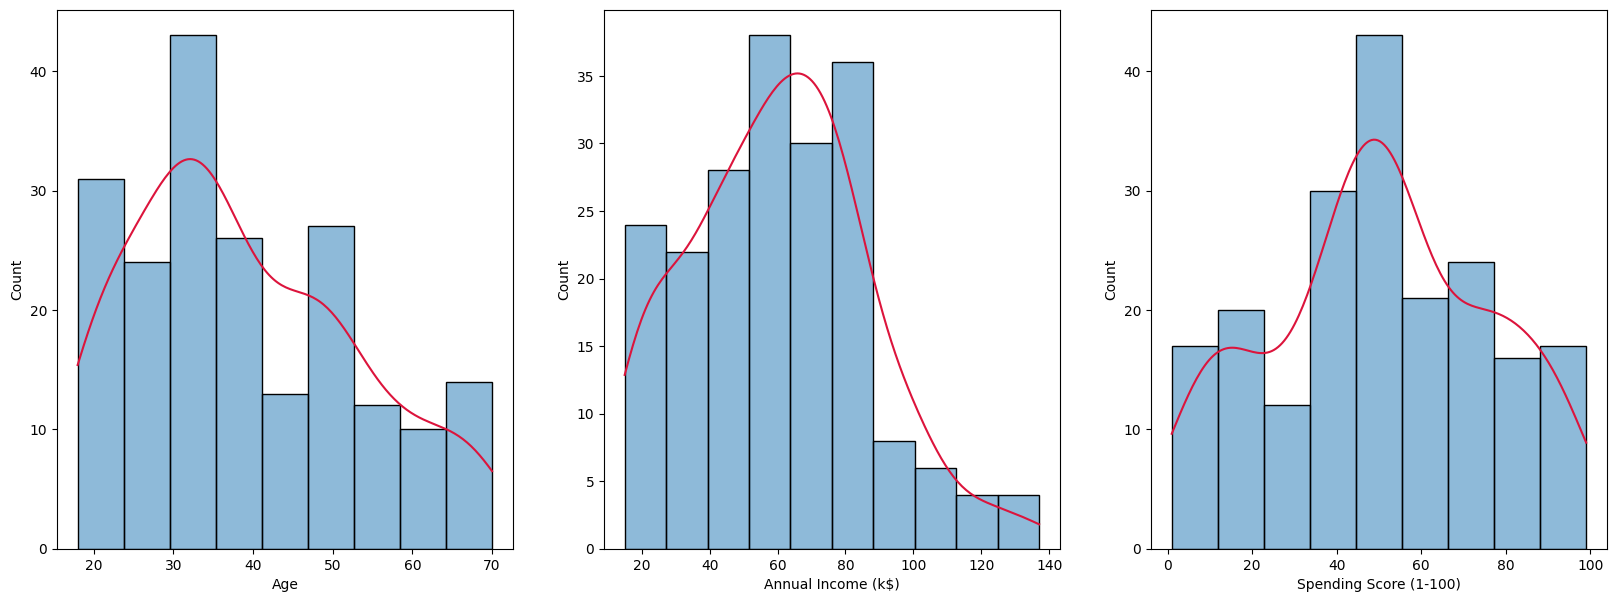

In [15]:
f, axes = plt.subplots(2,2 , figsize=(20, 7), sharex=False)
pos = 1
for i, feature in enumerate(continuous_features):

  plt.subplot(1 , 3 , pos)
  ax = sns.histplot(data=customer_df, x = feature,kde=True,palette="husl") # ax=axes[i%2, i//2]
  ax.lines[0].set_color('crimson')
  pos = pos + 1

In [16]:
# get the features except object types
numeric_feats = customer_df.dtypes[customer_df.dtypes != 'object'].index

# check the skew of all numerical features
skewed_feats = customer_df[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending = False)
print('\n Skew in numberical features: \n')
skewness_df = pd.DataFrame({'Skew' : skewed_feats})
print(skewness_df.head(10))


 Skew in numberical features: 

                            Skew
Age                     0.481919
Annual Income (k$)      0.319424
CustomerID              0.000000
Spending Score (1-100) -0.046865


Above distribution shows that:
- The distribution of continuous features are normally distributed.


### Check Distribution - Categorical

<Axes: xlabel='Gender', ylabel='count'>

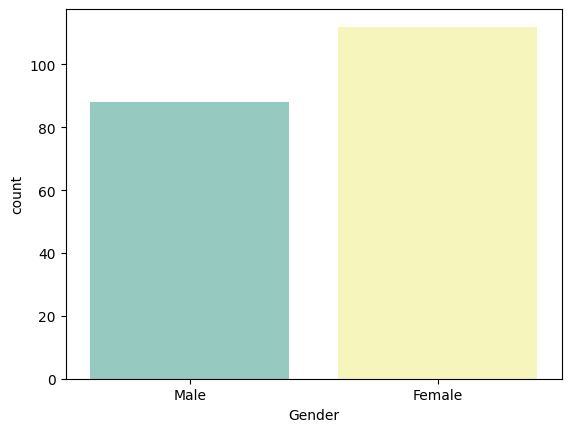

In [17]:
sns.countplot(x='Gender', data=customer_df, palette="Set3")

- Let's see how gender of customers affects to all other features.

c:\Users\matth\anaconda3\envs\textS\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


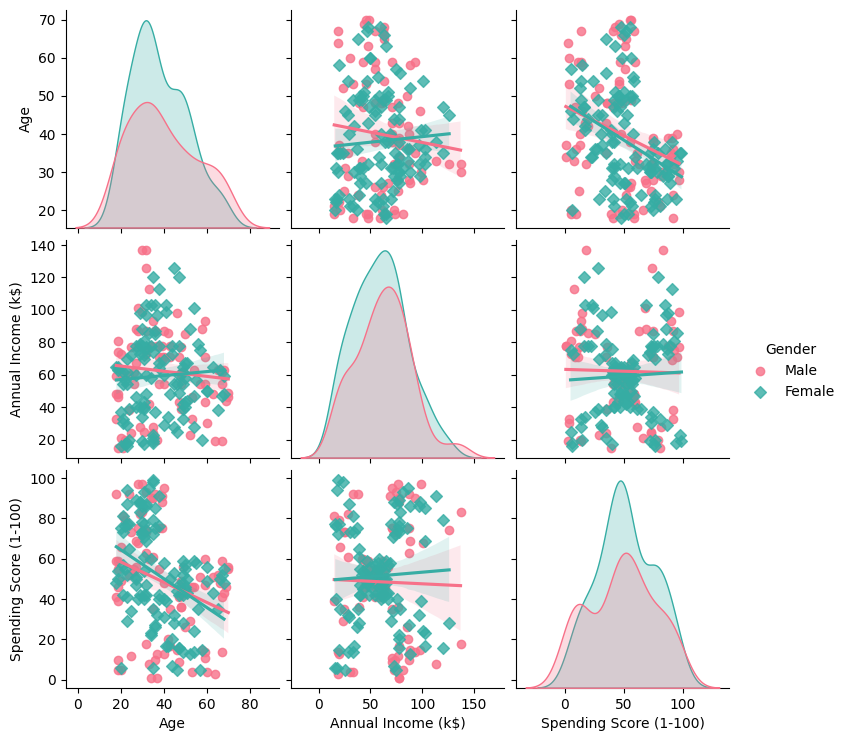

In [18]:
#Pairplot 
sns.pairplot(customer_df, vars=["Age", "Annual Income (k$)", "Spending Score (1-100)"],  kind ="reg", hue = "Gender", palette="husl", markers = ['o','D'])

### Data Correlation

C:\Users\matth\AppData\Local\Temp\ipykernel_15372\2964960606.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  customer_corr = customer_df.corr(method='spearman')


<Axes: >

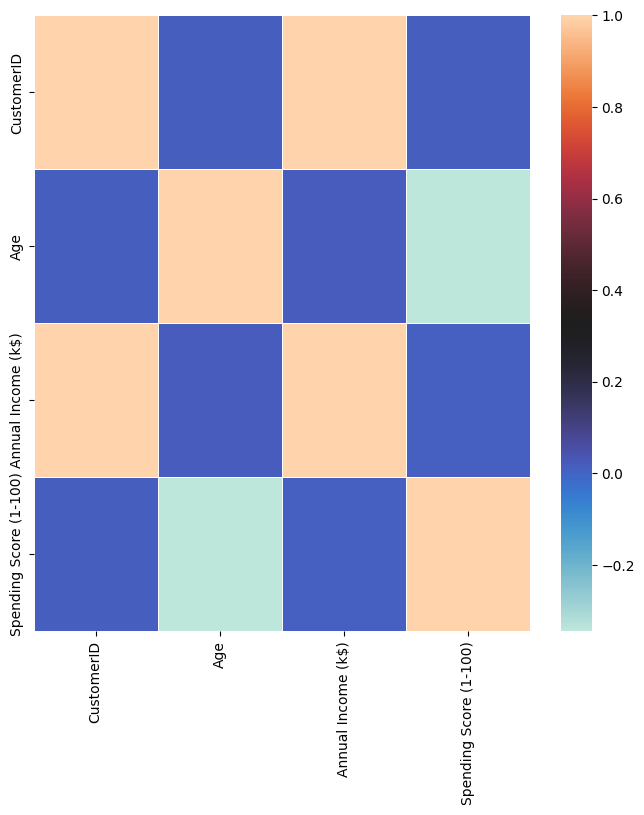

In [19]:
customer_corr = customer_df.corr(method='spearman')
plt.figure(figsize=(8,8))
sns.heatmap(customer_corr, cmap="icefire", linewidths=.5) #'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r'

# **Feature Engineering**

In [20]:
customer_df.drop(columns='CustomerID',axis=1,inplace=True) # drop columns

In [21]:
# Generate one-hot dummy columns
customer_df = pd.get_dummies(customer_df).reset_index(drop=True)

# **Model Development**

c:\Users\matth\anaconda3\envs\textS\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\matth\anaconda3\envs\textS\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\matth\anaconda3\envs\textS\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\matth\anaconda3\envs\textS\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\mat

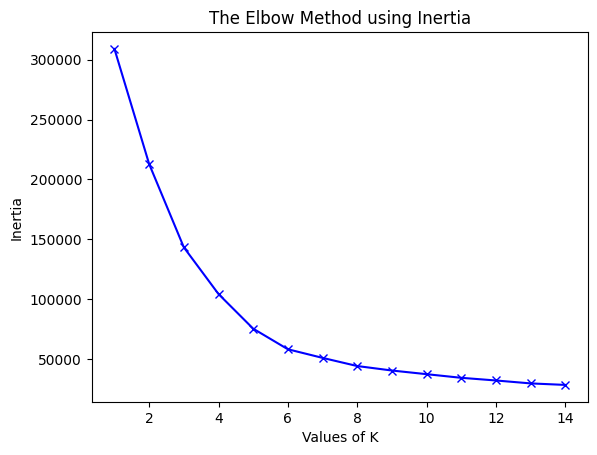

In [22]:
inertia = []
range_val = range(1,15)
for i in range_val:
  kmean = KMeans(n_clusters=i)
  kmean.fit_predict(pd.DataFrame(customer_df))
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

- From the above elbow method we see that **K = 5** is the best K value for our clustering

### K-Means Clustering

In [24]:
kmeans_model=KMeans(5)
kmeans_clusters = kmeans_model.fit_predict(customer_df)


c:\Users\matth\anaconda3\envs\textS\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Cluster Visualization

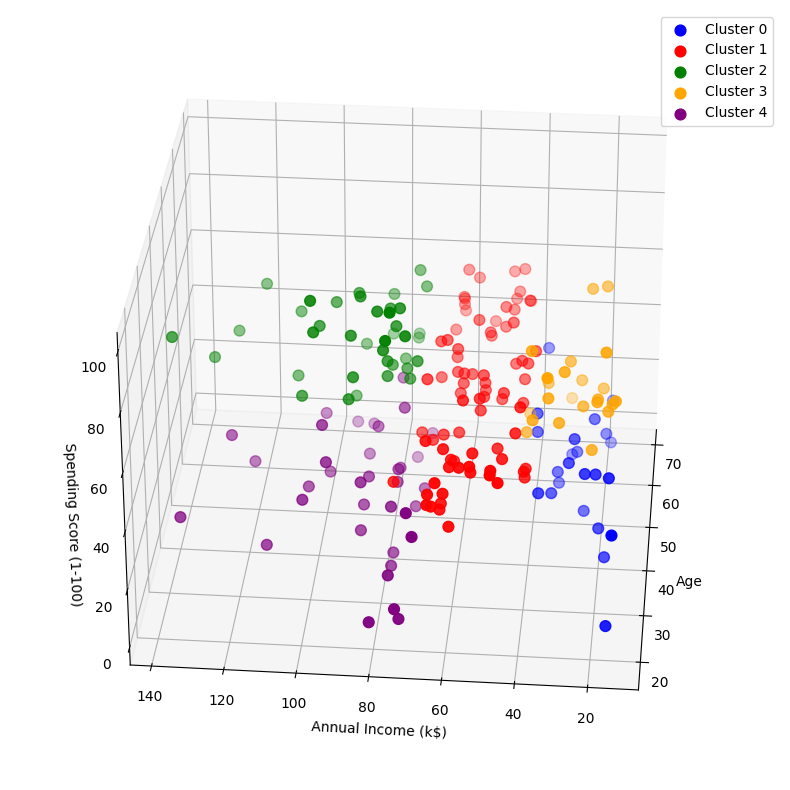

In [27]:
customer_df["label"] = kmeans_clusters

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define cluster labels and colors
cluster_labels = [0, 1, 2, 3, 4]
cluster_colors = ['blue', 'red', 'green', 'orange', 'purple']

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster separately with label and color
for label, color in zip(cluster_labels, cluster_colors):
    ax.scatter(customer_df.Age[customer_df.label == label],
               customer_df["Annual Income (k$)"][customer_df.label == label],
               customer_df["Spending Score (1-100)"][customer_df.label == label],
               c=color, s=60, label=f'Cluster {label}')

ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')

# Add legend
ax.legend()

plt.show()


### Random Predictions (testing)

In [33]:
print(kmeans_model.predict([[100, 100, 100, 100, 100]]))

[2]


c:\Users\matth\anaconda3\envs\textS\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [34]:
print(kmeans_model.predict([[200, 20, 150, 100, 35]]))

[3]


c:\Users\matth\anaconda3\envs\textS\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
